<a href="https://colab.research.google.com/github/AmaanRai1/DS-340-Group-8/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list
from joblib import Parallel, delayed

## **Data**

In [ ]:
# different file adresses for 3 different index data, only one them should be active
#file_address = 'https://raw.githubusercontent.com/AmaanRai1/DS-340-Group-8/refs/heads/main/ibex.csv'
#file_address = 'https://raw.githubusercontent.com/AmaanRai1/DS-340-Group-8/refs/heads/main/dji.csv'
file_address = 'https://raw.githubusercontent.com/AmaanRai1/DS-340-Group-8/refs/heads/main/gdaxi.csv'

# extracting name of the index from file_address
index_name = file_address.split('/')[-1].split('.')[0].upper()

# Read the CSV file into a DataFrame
df = pd.read_csv(file_address)

# Convert the 'date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Drop 'Volume' and 'Adj Close' columns
df = df.drop(['Volume', 'Adj Close'], axis=1)

/var/folders/td/dz_wwxjj7sq2s6rq_ydp1t3h0000gn/T/ipykernel_2071/2031736207.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,6973.390137,7026.620117,6969.830078,6989.740234
2011-01-04,6979.680176,7025.859863,6952.020020,6975.350098
2011-01-05,6966.080078,6967.240234,6842.899902,6939.819824
2011-01-06,6949.479980,7047.589844,6949.069824,6981.390137
2011-01-07,6991.549805,7010.890137,6939.879883,6947.839844
...,...,...,...,...
2019-12-19,13226.700200,13248.980470,13140.219730,13211.959960
2019-12-20,13210.259770,13324.110350,13201.799800,13318.900390
2019-12-23,13304.769530,13331.860350,13285.549800,13300.980470


In [ ]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Step 2: Further split the train data into training and validation sets (80/20 split, or adjust as needed)
validation_split = int(0.8 * len(train_data))

train_data_final = train_data.iloc[:validation_split]  # 80% for training
validation_data = train_data.iloc[validation_split:]  # 20% for validation

# Initialize the scaler and fit it only on the training data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_final[['Open', 'Close', 'High', 'Low']])

# Use the fitted scaler to transform validation and test data
validation_data_scaled = scaler.transform(validation_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.transform(test_data[['Open', 'Close', 'High', 'Low']])

# Convert scaled data back to DataFrames for consistency in later processing steps
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=train_data_final.index)
validation_data_scaled = pd.DataFrame(validation_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=validation_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=test_data.index)

In [ ]:
def split_data_x(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)

    return out

In [ ]:
def split_data_y(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    df = df['Close'] # only need the close price as y
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index + time_window])

    out = np.array(data)
    out = np.expand_dims(out, axis=1)

    return out

# **Strategies**

In [ ]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [ ]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()

    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()

    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])

    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades

    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])

    return metrics_df

## **TEMA**

In [ ]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean()

In [ ]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [ ]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    """
    Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        mid_range (list): A list of mid-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []

    # Iterate over all combinations of short, mid, and long periods
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:

            # Calculate TEMA strategy performance for the combination of periods
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]

            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))

    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_combinations, best_c_strategy

In [ ]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
# short_range = range(2, 5)
# mid_range = range(5, 7)
# long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (15, 16, 17)
Combination 2: (14, 18, 77)
Combination 3: (11, 20, 21)
Combination 4: (15, 17, 18)
Combination 5: (14, 17, 18)
Best CStrategy: [1.1406989881534797, 1.1360344701790723, 1.1320741380280648, 1.1314409207061746, 1.1305201639599793]


In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination

    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period,)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (15, 16, 17)
Profit Factor: 1.0924220195844727

Combination 2: (14, 18, 77)
Profit Factor: 0.9379749141028938

Combination 3: (11, 20, 21)
Profit Factor: 1.068844471399768

Combination 4: (15, 17, 18)
Profit Factor: 1.0850551252206113

Combination 5: (14, 17, 18)
Profit Factor: 1.0735750725169906



In [ ]:
print(best_tema_params[0], best_tema_params[1], best_tema_params[2])

15 16 17


In [ ]:
tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,GDAXI,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,NaN,NaN,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,NaN,NaN,NaN,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13204.179782,13200.696619,13197.097299,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.248745,1.065609,2631.76953,769.44045
2019-12-20,13318.90039,13218.519858,13214.602945,13210.630976,1,0.008062,0.008062,106.94043,106.94043,0.0,1.258853,1.074234,2738.70996,876.38088
2019-12-23,13300.98047,13228.827434,13224.765007,13220.669808,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.257159,1.072789,2720.79004,858.46096


In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


## **MACD**

In [ ]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """

    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs().replace(2,1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    """
    Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.
        signal_range (list): A list of signal line period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []

    # Iterate over all combinations of short, long, and signal periods
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:

            # Calculate MACD strategy performance for the combination of periods
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]

            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))

    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_combinations, best_c_strategy

In [ ]:
# Define the parameter ranges
short_range = range(2, 10)
long_range = range(5, 35)
signal_range = range(5, 20)

# test parameters
# short_range = range(2, 5)
# long_range = range(5, 7)
# signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (4, 5, 5)
Combination 2: (3, 6, 5)
Combination 3: (3, 5, 6)
Combination 4: (2, 8, 5)
Combination 5: (2, 5, 8)
Best CStrategy: [2.955655504626256, 2.924800811375486, 2.924800811375486, 2.886587579080479, 2.886587579080479]


In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination

    # Run the strategy with the current combination
    strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (4, 5, 5)
Profit Factor: 1.0167370508162197

Combination 2: (3, 6, 5)
Profit Factor: 0.973250364312905

Combination 3: (3, 5, 6)
Profit Factor: 0.973250364312905

Combination 4: (2, 8, 5)
Profit Factor: 0.9887143198127287

Combination 5: (2, 5, 8)
Profit Factor: 0.9887143198127287



In [ ]:
print(best_macd_params[0], best_macd_params[1], best_macd_params[2])

4 5 5


In [ ]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,GDAXI,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,NaN,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,NaN,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,10681.867012,NaN,NaN,NaN,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,10734.830864,10722.388062,12.442803,NaN,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13241.731030,13241.349243,0.381787,6.787242,-1,-0.000772,0.000772,-10.20020,10.20020,0.0,1.248745,1.029545,2631.76953,436.14356
2019-12-20,13318.90039,13272.598774,13267.199625,5.399149,6.324544,-1,0.008062,-0.008062,106.94043,-106.94043,0.0,1.258853,1.021278,2738.70996,329.20313
2019-12-23,13300.98047,13283.951452,13278.459907,5.491546,6.046878,-1,-0.001346,0.001346,-17.91992,17.91992,0.0,1.257159,1.022654,2720.79004,347.12305


In [ ]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,47.0,222.89259,1.016737,4.742396,-1372.20216


## **RSI**

In [ ]:
def rsi_strategy(df, symbol, rsi_period):
    """
    Implement a trading strategy using RSI (Relative Strength Index).

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_period (int): The period for the RSI calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.
    """

    # Preprocess the data (e.g., calculate price changes)
    df = df_change(df, symbol)
    temp = df.copy()  # Create a copy of the DataFrame

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Generate trading signals based on RSI thresholds
    temp['Position'] = np.where(temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
                                np.where(temp['RSI'] > 70, -1, 0))  # Sell when RSI > 70 (Overbought)

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

def calculate_rsi(series, period):
    """Calculates the Relative Strength Index (RSI)."""
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [ ]:
def optimize_rsi_parameters(df, symbol, rsi_range):
    """
    Optimize RSI (Relative Strength Index) parameters by finding the best period based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_range (list): A list of RSI period values to consider.

    Returns:
        list: A list of best RSI periods.
        list: A list of corresponding CStrategy values.
    """
    top_combinations = []

    # Iterate over all possible RSI periods
    for rsi_period in rsi_range:
        # Calculate the RSI strategy performance for the given period
        result = rsi_strategy(df, symbol, rsi_period)
        c_strategy = result['CStrategy'].iloc[-1]  # Get the final CStrategy value

        # Use a heap to maintain the top 5 combinations based on CStrategy
        if len(top_combinations) < 5:
            heapq.heappush(top_combinations, (c_strategy, rsi_period))
        else:
            heapq.heappushpop(top_combinations, (c_strategy, rsi_period))

    # Get the top 5 RSI periods with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_periods = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_periods, best_c_strategy

In [ ]:
# Define the parameter range for RSI periods
rsi_range = range(2, 30)  # Adjust this range based on your needs

# Test smaller ranges (for testing purposes)
# rsi_range = range(2, 5)

# Run the optimization
best_periods, best_c_strategy = optimize_rsi_parameters(train_data, index_name, rsi_range)

# Extract the best RSI period
best_rsi_period = best_periods[0]

# Print the best periods and their corresponding CStrategy values
print("Best RSI Periods:")
for i, period in enumerate(best_periods):
    print(f"Period {i+1}: {period} with CStrategy: {best_c_strategy[i]}")

print(f"\nBest RSI Period: {best_rsi_period}")


Best RSI Periods:
Period 1: 5 with CStrategy: 1.4498055919088544
Period 2: 13 with CStrategy: 1.4482066638126252
Period 3: 8 with CStrategy: 1.4201882620512079
Period 4: 10 with CStrategy: 1.3555477093894663
Period 5: 16 with CStrategy: 1.3271021075036666

Best RSI Period: 5


In [ ]:
def calculate_profit_factor(strategy_returns):
    """
    Calculate the profit factor for a given strategy.

    Args:
        strategy_returns (pd.Series): A series of strategy returns.

    Returns:
        float: The profit factor (ratio of gross profit to gross loss).
    """
    # Separate profits and losses
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = abs(strategy_returns[strategy_returns < 0].sum())

    # Avoid division by zero by checking for zero gross loss
    if gross_loss == 0:
        return float('inf')  # Return infinity if there are no losses

    return gross_profit / gross_loss

In [ ]:
print(f"Printing five of the best RSI period combinations:\n")

for i, period in enumerate(best_periods):
    # Run the RSI strategy with the current period
    strategy_result = rsi_strategy(test_data, index_name, period)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Period {i+1}: {period}")
    print("Profit Factor:", pf_factor)
    print()


Printing five of the best RSI period combinations:

Period 1: 5
Profit Factor: 1.2728715203029541

Period 2: 13
Profit Factor: 0.901634720102489

Period 3: 8
Profit Factor: 0.8838836935914389

Period 4: 10
Profit Factor: 1.0638955732607642

Period 5: 16
Profit Factor: 1.0891328154369797



In [ ]:
rsi_strategy(test_data, index_name, best_rsi_period)

,GDAXI,RSI,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,0,-0.015577,-0.0,-163.53027,-0.0,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,0,0.033144,0.0,351.03027,0.0,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,0,-0.001848,-0.0,-19.88086,-0.0,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,68.945596,0,0.005213,0.0,56.17090,0.0,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,48.732098,0,-0.000772,-0.0,-10.20020,-0.0,0.0,1.248745,1.099444,2631.76953,1110.94044
2019-12-20,13318.90039,54.230854,0,0.008062,0.0,106.94043,0.0,0.0,1.258853,1.099444,2738.70996,1110.94044
2019-12-23,13300.98047,33.360446,0,-0.001346,-0.0,-17.91992,-0.0,0.0,1.257159,1.099444,2720.79004,1110.94044


In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1110.94044,1.272872,13.069888,-959.13965


# **Prediction**

## **Linear Regression**

In [ ]:
# setting up the lookback parameter
time_window = 6

In [ ]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data, time_window)
y_train = split_data_y(train_data, time_window)
x_val = split_data_x(validation_data, time_window)
y_val = split_data_y(validation_data, time_window)
x_test = split_data_x(test_data, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# printing shape of x and y data
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2018, 24)
y_train.shape =  (2018, 1)
x_val.shape =  (399, 24)
y_val.shape =  (399, 1)
x_test.shape =  (245, 24)
y_test.shape =  (245, 1)


In [ ]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
# Evaluate the model on validation data
y_val_pred = regression_model.predict(x_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {val_mae}')

Validation MAE: 81.6004508492306


In [ ]:
# Evaluate the model on test data
y_test_pred = regression_model.predict(x_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MAE: {test_mae}')

Test MAE: 76.3701420979193


In [ ]:
# Evaluate on the validation set
y_val_pred = regression_model.predict(x_val)

# RMSE
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Validation RMSE: {val_rmse}')

# sMAPE
val_smape = np.mean(np.abs((y_val - y_val_pred) / (np.abs(y_val) + np.abs(y_val_pred))) * 200)
print(f'Validation sMAPE: {val_smape}')

# MAPE
val_mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
print(f'Validation MAPE: {val_mape}')

# Evaluate on the test set
y_test_pred = regression_model.predict(x_test)

# RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_rmse}')

# sMAPE for test set
test_smape = np.mean(np.abs((y_test - y_test_pred) / (np.abs(y_test) + np.abs(y_test_pred))) * 200)
print(f'Test sMAPE: {test_smape}')

# MAPE for test set
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Test MAPE: {test_mape}')

Validation RMSE: 106.10076619624773
Validation sMAPE: 0.6623127345194677
Validation MAPE: 0.6629027900222378
Test RMSE: 102.54610207706916
Test sMAPE: 0.6335927413286304
Test MAPE: 0.6335567295884226


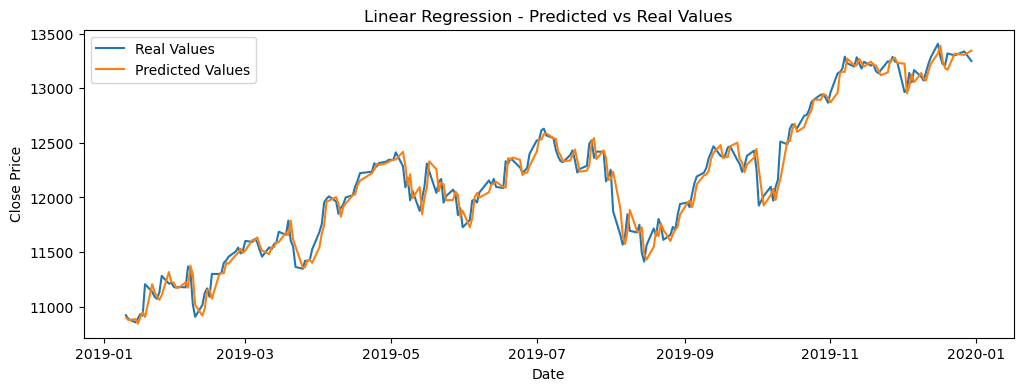

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_test_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# saving the prediction price for further use
y_pred_lr = pd.DataFrame(y_test_pred)

# Rename the column
y_pred_lr = y_pred_lr.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_lr = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_lr],
                      ignore_index=True)

## **ANN**

In [ ]:
# Define the updated ANN model with Dropout
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        # Reduce number of layers/neuron counts as needed
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)  # Dropout layer with 30% dropout rate

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)  # Apply dropout after first layer
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

In [ ]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_val = split_data_x(validation_data_scaled, time_window)
y_val = split_data_y(validation_data, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [ ]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
model = ANNModel(input_size=x_train.shape[1])  # Define input size based on x_train

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Implement early stopping
early_stop_threshold = 10  # Stop if no improvement after 10 iterations
best_val_loss = float('inf')
no_improvement_count = 0

In [ ]:
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Early stopping at epoch 41


In [ ]:
# Compute predictions on the test data
y_pred = model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Scale the test_data['Close'] using the same scaler used for training data
temp = scaler.fit_transform(test_data[['Close']])

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array
y_test = y_test.detach().numpy()

In [ ]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 933.923
Root Mean Squared Error (RMSE): 1020.4525
Symmetric Mean Absolute Percentage Error (sMAPE): 3.7632582
Mean Absolute Percentage Error (MAPE): 7.890079170465469


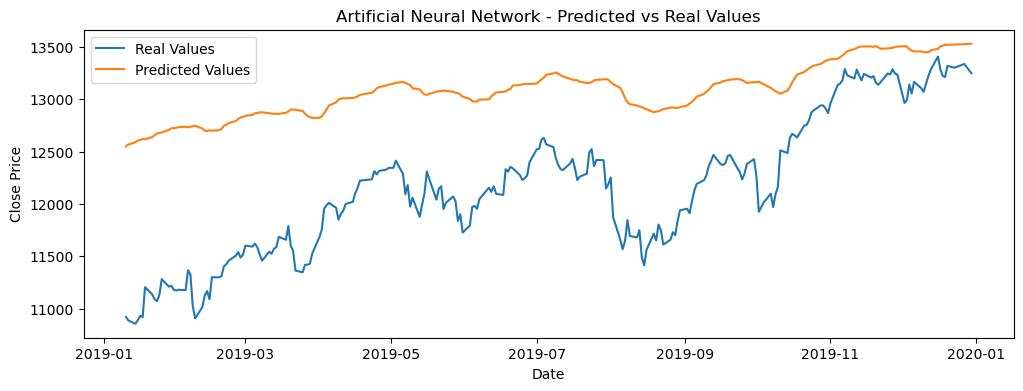

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# saving the prediction price for further use
y_pred_ann = pd.DataFrame(y_pred)

# Rename the column
y_pred_ann = y_pred_ann.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_ann = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_ann],
                      ignore_index=True)

# **LSTM**

In [ ]:
# Define the updated LSTM model with increased hidden size and layers
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Get the last timestep output
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Data preparation (match style with ANN)
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_val = split_data_x(validation_data_scaled, time_window)
y_val = split_data_y(validation_data, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# Transform numpy arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Ensure x_train, x_val, and x_test have three dimensions
if x_train.dim() == 2:
    x_train = x_train.unsqueeze(-1)  # Add a dimension at the end
if x_val.dim() == 2:
    x_val = x_val.unsqueeze(-1)
if x_test.dim() == 2:
    x_test = x_test.unsqueeze(-1)

In [ ]:
# Set up hyperparameters
input_size = x_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
dropout = 0.3
learning_rate = 0.001
num_epochs = 5000
early_stop_threshold = 10

In [ ]:
# Instantiate model, loss function, and optimizer
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
no_improvement_count = 0

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Early stopping at epoch 24


In [ ]:
# Predictions and inverse transformation
model.eval()
with torch.no_grad():
    y_pred = model(x_test).squeeze().cpu().numpy()
    y_test = y_test.cpu().numpy()

# Rescale predictions
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 534.2744
Root Mean Squared Error (RMSE): 660.34827
Symmetric Mean Absolute Percentage Error (sMAPE): 2.1994069
Mean Absolute Percentage Error (MAPE): 4.320773854851723


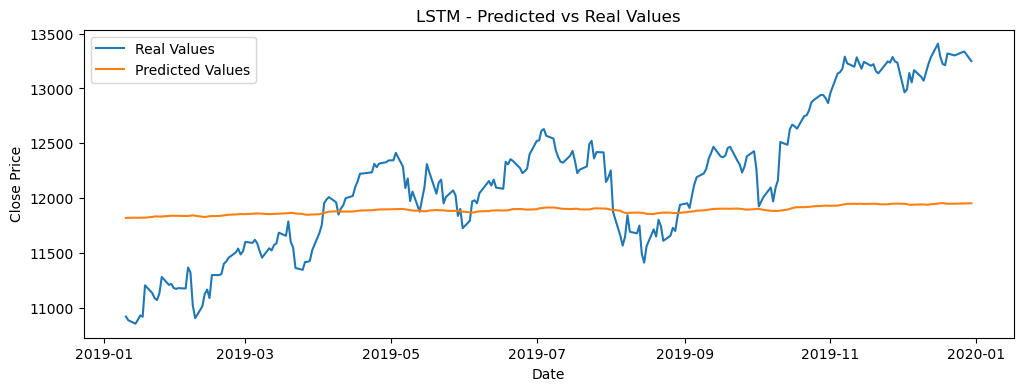

In [ ]:
# Plotting the predicted vs real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# Generating predictions on the test set
model.eval()
with torch.no_grad():
    y_pred_lstm = model(x_test)

# If data was scaled, apply inverse scaling to predictions (optional)
# Uncomment if using a scaler, e.g., MinMaxScaler
# y_pred_lstm = scaler.inverse_transform(y_pred_lstm.numpy())

# Convert predictions to a DataFrame for easier handling
y_pred_lstm = pd.DataFrame(y_pred_lstm.numpy(), columns=['Predicted'], index=test_data.index[:len(y_pred_lstm)])

# Apply a moving average to smooth predictions (optional)
y_pred_lstm['Predicted'] = y_pred_lstm['Predicted'].rolling(window=3, min_periods=1).mean()

# Display the first few predictions
print(y_pred_lstm.head())

            Predicted
Date                 
2019-01-02   0.469141
2019-01-03   0.469366
2019-01-04   0.469563
2019-01-07   0.469670
2019-01-08   0.469787


# **Hybrid Strategies**

## **Strategy 1**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm)


,GDAXI,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-10,10921.58984,NaN,NaN,NaN,0.469141,1,0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-11,10887.45996,NaN,NaN,NaN,0.469366,1,0,1,-0.003130,-0.003130,-34.12988,-34.12988,0.0,0.996875,0.996875,-34.12988,-34.12988
2019-01-14,10855.91016,NaN,NaN,NaN,0.469563,1,0,1,-0.002902,-0.002902,-31.54980,-31.54980,0.0,0.993986,0.993986,-65.67968,-65.67968
2019-01-15,10891.79004,NaN,NaN,NaN,0.469670,1,0,1,0.003300,0.003300,35.87988,35.87988,0.0,0.997271,0.997271,-29.79980,-29.79980
2019-01-16,10931.24023,NaN,NaN,NaN,0.469787,1,0,1,0.003615,0.003615,39.45019,39.45019,0.0,1.000884,1.000884,9.65039,9.65039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13204.179782,13200.696619,13197.097299,0.513953,1,1,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.209710,1.209710,2290.37012,2290.37012
2019-12-20,13318.90039,13218.519858,13214.602945,13210.630976,0.513364,1,1,1,0.008062,0.008062,106.94043,106.94043,0.0,1.219502,1.219502,2397.31055,2397.31055
2019-12-23,13300.98047,13228.827434,13224.765007,13220.669808,0.512771,1,1,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.217861,1.217861,2379.39063,2379.39063


In [ ]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

/var/folders/td/dz_wwxjj7sq2s6rq_ydp1t3h0000gn/T/ipykernel_2071/4127296777.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  avg_net_trade = net_profit / num_trades


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,0.0,2327.41993,1.278632,inf,-1217.23047


In [ ]:
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


### **hMACD**

In [ ]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm)

,GDAXI,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-10,10921.58984,NaN,NaN,NaN,NaN,0.469141,1,0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-11,10887.45996,NaN,NaN,NaN,NaN,0.469366,1,0,1,-0.003130,-0.003130,-34.12988,-34.12988,0.0,0.996875,0.996875,-34.12988,-34.12988
2019-01-14,10855.91016,NaN,NaN,NaN,NaN,0.469563,1,0,1,-0.002902,-0.002902,-31.54980,-31.54980,0.0,0.993986,0.993986,-65.67968,-65.67968
2019-01-15,10891.79004,10884.138386,NaN,NaN,NaN,0.469670,1,0,1,0.003300,0.003300,35.87988,35.87988,0.0,0.997271,0.997271,-29.79980,-29.79980
2019-01-16,10931.24023,10904.567707,10902.579920,1.987788,NaN,0.469787,1,0,1,0.003615,0.003615,39.45019,39.45019,0.0,1.000884,1.000884,9.65039,9.65039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13241.731030,13241.349243,0.381787,6.787242,0.513953,1,-1,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.209710,1.209710,2290.37012,2290.37012
2019-12-20,13318.90039,13272.598774,13267.199625,5.399149,6.324544,0.513364,1,-1,1,0.008062,0.008062,106.94043,106.94043,0.0,1.219502,1.219502,2397.31055,2397.31055
2019-12-23,13300.98047,13283.951452,13278.459907,5.491546,6.046878,0.512771,1,-1,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.217861,1.217861,2379.39063,2379.39063


In [ ]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,2327.41993,1.278632,2327.41993,-1217.23047


In [ ]:
calculate_metrics(hmacd_strategy(validation_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


## **hRSI**

In [ ]:
def hrsi_strategy(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the Relative Strength Index (RSI) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Align the dataframe with the predictions
    df = df_change(df, symbol)  # Preprocess data (e.g., handle NaNs or changes)
    adjusted_split = len(df) - len(y_pred)  # Find the index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame
    temp = df.copy()  # Make a copy of the aligned dataframe

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Determine strategy position based on RSI
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell when RSI > 70 (Overbought)
    )

    # Generate final trading signals by combining strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
        np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0)
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm)

,GDAXI,RSI,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-10,10921.58984,NaN,0.469141,1,0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-11,10887.45996,NaN,0.469366,1,0,1,-0.003130,-0.003130,-34.12988,-34.12988,0.0,0.996875,0.996875,-34.12988,-34.12988
2019-01-14,10855.91016,NaN,0.469563,1,0,1,-0.002902,-0.002902,-31.54980,-31.54980,0.0,0.993986,0.993986,-65.67968,-65.67968
2019-01-15,10891.79004,NaN,0.469670,1,0,1,0.003300,0.003300,35.87988,35.87988,0.0,0.997271,0.997271,-29.79980,-29.79980
2019-01-16,10931.24023,53.421887,0.469787,1,0,1,0.003615,0.003615,39.45019,39.45019,0.0,1.000884,1.000884,9.65039,9.65039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,48.732098,0.513953,1,0,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.209710,1.209710,2290.37012,2290.37012
2019-12-20,13318.90039,54.230854,0.513364,1,0,1,0.008062,0.008062,106.94043,106.94043,0.0,1.219502,1.219502,2397.31055,2397.31055
2019-12-23,13300.98047,33.360446,0.512771,1,0,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.217861,1.217861,2379.39063,2379.39063


In [ ]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,2327.41993,1.278632,2327.41993,-1217.23047


In [ ]:
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


## **Strategy 2**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy_2(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,17.0,-223.09958,0.966344,-13.123505,-1335.4912


In [ ]:
calculate_metrics(htema_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,1561.791,1.168183,104.1194,-1220.04101


### **hMACD**

In [ ]:
def hmacd_strategy_2(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,55.0,5707.23629,1.845045,103.767933,-836.97167


In [ ]:
calculate_metrics(hmacd_strategy_2(validation_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,33.0,4796.04883,1.540385,145.334813,-701.18067


### **hRSI**

In [ ]:
def hrsi_strategy_2(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the RSI (Relative Strength Index) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Preprocess data and align with predictions
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame to align with y_pred
    temp = df.copy()  # Create a copy of the trimmed DataFrame

    # Calculate RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and generate prediction positions
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Generate RSI-based strategy positions
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy if RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell if RSI > 70 (Overbought)
    )

    # Generate final trading signals using strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,  # Buy if both signals agree
        np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0)  # Sell if either signals sell
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,83.0,1148.86036,1.290831,13.841691,-959.13965


In [ ]:
calculate_metrics(hrsi_strategy_2(validation_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,69.0,2700.17284,1.404796,39.13294,-1090.22949


# **Outputs**

## Strategy

### TEMA

#### tema_strategy

In [ ]:
# Validation
calculate_metrics(tema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,21.0,563.50196,1.049631,26.833427,-2000.90917


In [ ]:
# Test
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


#### htema_strategy

##### Linear Regression

In [ ]:
# Validation
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,13.0,729.41896,1.080029,56.109151,-1772.33984


In [ ]:
# Test
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,19.0,5112.78024,1.757027,269.093697,-543.28027


##### Artifical Neural Network

In [ ]:
# Validation
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,14.0,874.81055,1.095338,62.486468,-1307.01074


In [ ]:
# Test
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


##### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


In [ ]:
# Test
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

/var/folders/td/dz_wwxjj7sq2s6rq_ydp1t3h0000gn/T/ipykernel_2071/4127296777.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  avg_net_trade = net_profit / num_trades


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,0.0,2327.41993,1.278632,inf,-1217.23047


#### htema_strategy_2

##### Linear Regression

In [ ]:
# Validation
calculate_metrics(htema_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,1561.791,1.168183,104.1194,-1220.04101


In [ ]:
# Test
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,64.0,9891.90921,3.304473,154.561081,-612.37012


##### Artificial Neural Network

In [ ]:
# Validation
calculate_metrics(htema_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,6.0,2814.31933,1.300864,469.053222,-1235.61035


In [ ]:
# Test
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,-2327.41993,0.782086,-1163.709965,-2551.75


##### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(htema_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,12.0,1589.73046,1.172161,132.477538,-1307.01074


In [ ]:
# Test
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,17.0,-223.09958,0.966344,-13.123505,-1335.4912


## MACD

### macd_strategy

In [ ]:
# Validation
calculate_metrics(macd_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,33.0,-3735.85058,0.780911,-113.207593,-4106.32031


In [ ]:
# Test
calculate_metrics(macd_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,731.13965,1.085115,48.742643,-961.05078


### hmacd_strategy

#### Linear Regression

In [ ]:
# Validation
calculate_metrics(hmacd_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,-1570.37792,0.870111,-104.691861,-2219.10742


In [ ]:
# Test
calculate_metrics(hmacd_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,48.0,9460.30859,3.163212,197.089762,-407.19923


#### Artificial Neural Network

In [ ]:
# Validation
calculate_metrics(hmacd_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,24.0,-2527.85838,0.783381,-105.327433,-3176.58788


In [ ]:
# Test
calculate_metrics(hmacd_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,731.13965,1.085115,48.742643,-961.05078


#### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(hmacd_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


In [ ]:
# Test
calculate_metrics(hmacd_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,2327.41993,1.278632,2327.41993,-1217.23047


### hmacd_strategy_2

#### Linear Regression

In [ ]:
# Validation
calculate_metrics(hmacd_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,17.0,217.9795,1.030885,12.822324,-2042.55273


In [ ]:
# Test
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,43.0,5469.03025,1.872319,127.18675,-704.54004


#### Artificial Neural Network

In [ ]:
# Validation
calculate_metrics(hmacd_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,3.0,2573.37988,1.282839,857.793293,-1235.61035


In [ ]:
# Test
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2327.41993,0.782086,-2327.41993,-2551.75


#### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(hmacd_strategy_2(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,18.0,-1987.64744,0.810732,-110.424858,-2423.24705


In [ ]:
# Test
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,14.0,861.02831,1.105426,61.502022,-902.0918


## RSI

### rsi_strategy

In [ ]:
# Validation
calculate_metrics(rsi_strategy(validation_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,125.0,-237.48829,0.973694,-1.899906,-1690.72851


In [ ]:
# Validation
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1110.94044,1.272872,13.069888,-959.13965


### hrsi_strategy

#### Linear Regression

In [ ]:
# Validation
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,32.0,-1163.7832,0.890562,-36.368225,-2013.58204


In [ ]:
# Test
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,93.0,10652.42089,7.016419,114.54216,-304.48047


#### Artificial Neural Network

In [ ]:
# Validation
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,80.0,409.23925,1.057564,5.115491,-1452.11914


In [ ]:
# Test
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1139.20997,1.282438,13.40247,-959.13965


#### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2722.37988,0.781694,-2722.37988,-3178.08984


In [ ]:
# Test
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,2327.41993,1.278632,2327.41993,-1217.23047


### hrsi_strategy_2

#### Linear Regression

In [ ]:
# Validation
calculate_metrics(hrsi_strategy_2(validation_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,69.0,2700.17284,1.404796,39.13294,-1090.22949


In [ ]:
# Test
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,87.0,4656.71874,1.960167,53.525503,-855.76953


#### Artificial Neural Network

In [ ]:
# Validation
calculate_metrics(hrsi_strategy_2(validation_data, index_name, best_rsi_period, y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,15.0,2525.07031,1.26777,168.338021,-1235.61035


In [ ]:
# Test
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,-2355.68946,0.779806,-1177.84473,-2551.75


#### Long Short-Term Memory

In [ ]:
# Validation
calculate_metrics(hrsi_strategy_2(validation_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,82.0,275.74023,1.040919,3.362686,-1090.22949


In [ ]:
# Test
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,83.0,1148.86036,1.290831,13.841691,-959.13965
